In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.metrics

In [73]:
data = pd.read_csv('/content/drive/MyDrive/College/PS - 1/Notebooks/clean_df.csv')
data.head()

,Unnamed: 0,Sample No.,Patient ID,Study ID,Age,Gender,BMI,Symptoms Presented,Symptoms Present?,Fever,Cough,Breathlessness,Travel History,Temp,SPO2,METHYLPREDNISOLONE,Low molecular weight heparin,Hydroxychloroquine,FABIFLU,REMDESIVIR,IVERMECTIN,ANTIBIOTICS,VITAMINs and zinc,Medicine Administered,Contact to NCOVID Patient,Co-morbid Condition,Co-morbidity?,Diabetes,Hypertension,Heart Condition,Hospital stay in days,Respiratory Support,Respiratory rate(breaths per minute),Outcome,O2 supplementation required,Ventilatory support required,qSOFA SCORE,RESPIRATORY FINDINGS,HEMOGLOBIN,TLC COUNT,PLATELET COUNT,RANDOM BLOOD SUGAR,UREA,CREATININE,SODIUM,POTASSIUM,CHLORIDE,TOTAL BILIRUBIN,DIRECT BILIRUBIN,SGOT,SGPT,TOTAL PROTEINS,ALBUMIN,ALKALINE PHOSPHATASE,C-REACTIVE PROTEINS,ECG,CXR,CORADS SCORE ON HRCT,PATIENT CATEGORY,PLASMA THERAPY,Age Above 60?,Temp Groups,CORADS 6
0,0,1013,IGIB1040201013,IGIB1040201013-1,0.551724,1,0.436782,"fever, cough,breathlessness",1,1,1,1,0,0.2,0.833333,1,1,1,1,1,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,18.0,1,0.3,0,1,0,0,Basal crepitations,0.854839,0.162996,0.030910,0.131285,0.209231,0.000172,0.542857,0.018793,0.862793,0.051282,0.047619,0.171097,0.355532,0.255556,0.300,0.127089,0.152271,sinus rhythm,normal,4.0,5a,No,0,0.2,0.0
1,1,1014,IGIB1040201014,IGIB1040201014-1,0.241379,0,0.804598,asymptomatic,0,0,0,0,0,0.5,0.666667,1,1,1,1,0,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,NaN,0,0.1,0,0,0,0,Basal crepitations,0.720430,0.072247,0.065827,0.061453,0.051077,0.000121,0.685714,0.011869,0.862793,0.000000,0.000000,0.046414,0.059076,0.333333,0.325,0.172501,0.009346,sinus rhythm,normal,0.0,5b,No,0,0.6,0.0
2,2,1015,IGIB1040201015,IGIB1040201015-1,0.264368,1,0.402299,asymptomatic,0,0,0,0,0,0.4,0.666667,1,1,1,1,0,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,11.0,0,0.1,0,0,0,0,Basal crepitations,0.854839,0.096035,0.090441,0.078212,0.029538,1.000000,1.000000,0.150346,0.000000,0.128205,0.095238,0.040295,0.048335,0.377778,0.400,0.259224,0.026437,sinus rhythm,normal,0.0,5b,No,0,0.4,0.0
3,3,1016,IGIB1040201016,IGIB1040201016-1,0.781609,1,0.321839,"fever, cough,breathlessness",1,1,1,1,0,0.4,0.666667,1,1,1,1,1,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,14.0,1,0.6,1,1,1,1,Basal crepitations,0.709677,0.118943,0.092158,0.125698,0.142154,0.000103,0.457143,0.012859,0.830508,0.538462,0.523810,0.124051,0.236842,0.300000,0.275,0.366446,0.443161,sinus rhythm,normal,5.0,4,No,1,0.4,0.0
4,4,1060,IGIB1040201060,IGIB1040201060-1,0.505747,1,1.000000,"fever,cough",1,1,1,0,0,0.8,0.666667,1,1,1,1,1,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,Psychiatric disorder,1,0,0,0,1.0,0,0.3,0,0,0,0,no any,0.736559,0.308370,0.141958,0.050279,0.052308,0.000103,0.000000,0.008902,0.733656,1.000000,0.952381,0.093671,0.277658,0.255556,0.125,0.546200,0.430297,sinus rhythm,normal,5.0,4,No,0,0.8,0.0


In [74]:
data.drop(columns=['Unnamed: 0'], inplace = True)

## Model

In [75]:
model = RandomForestClassifier(n_estimators=10)

In [76]:
def model_perf(x,y,model):
    cm = metrics.confusion_matrix(y, model.predict(x))
    plt.figure
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.savefig('covidseverity.png')
    accuracy = model.score(x,y)
    precision,recall,f1,support = sklearn.metrics.precision_recall_fscore_support(y, model.predict(x),average='binary')
    print("Accuracy Score = ",accuracy)
    print("Precision Score = ",precision)    
    print("Recall Score = ",recall)    
    print("F1 Score = ",f1)

## Initial factors

In [77]:
X = data[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)']]
Y = data['Outcome']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=0)

model.fit(Xtrain, ytrain);

Accuracy Score =  0.9694656488549618
Precision Score =  0.8636363636363636
Recall Score =  0.95
F1 Score =  0.9047619047619048


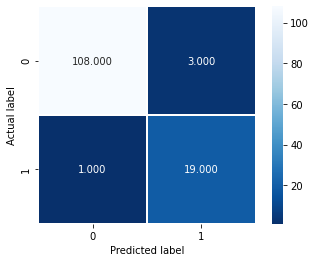

In [78]:
model_perf(x_train, y_train, model)

Accuracy Score =  0.9090909090909091
Precision Score =  0.5
Recall Score =  0.5
F1 Score =  0.5


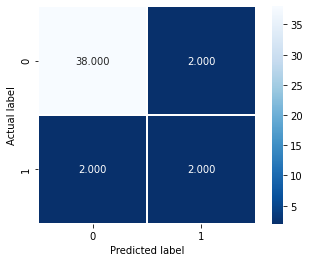

In [79]:
model_perf(Xtest, ytest, model)

## Initial Factors + Symptoms and Comorbidities


In [80]:
X = data[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension']]
Y = data['Outcome']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=0)

model.fit(Xtrain, ytrain);

Accuracy Score =  0.9770992366412213
Precision Score =  0.9473684210526315
Recall Score =  0.9
F1 Score =  0.9230769230769231


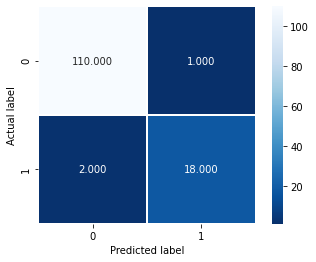

In [81]:
model_perf(Xtrain, ytrain, model)

Accuracy Score =  0.8863636363636364
Precision Score =  0.4
Recall Score =  0.5
F1 Score =  0.4444444444444445


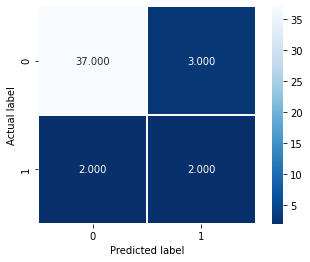

In [82]:
model_perf(Xtest, ytest, model)

## Initial Factors + Symptoms and Comorbidities + Blood

In [83]:
X = data[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
Y = data['Outcome']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=0)

model.fit(Xtrain, ytrain);

Accuracy Score =  0.9847328244274809
Precision Score =  1.0
Recall Score =  0.9
F1 Score =  0.9473684210526316


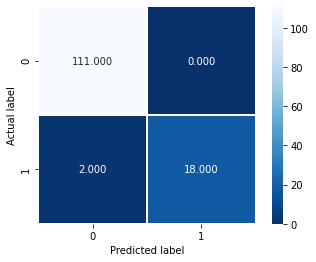

In [84]:
model_perf(Xtrain, ytrain, model)

Accuracy Score =  0.9545454545454546
Precision Score =  1.0
Recall Score =  0.5
F1 Score =  0.6666666666666666


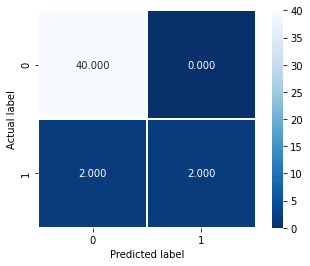

In [85]:
model_perf(Xtest, ytest, model)

## Future goals - 


1.   Compare accuracies of diff models using boxplots
2.   Make a class for different models

